# Establishment of ESG Factor 

### a) Importing Packages

In [6]:
#To Load Data in Colab
from google.colab import drive # Used to access Google Drive to import data
import shutil # Used to copy data from Google Drive
import pandas as pd
import os

#Inspecting Factor
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

ModuleNotFoundError: No module named 'google.colab'

### Importing Data

In [4]:
#Mount to Google Drive to be able to access data
drive.mount('/content/drive')

NameError: name 'drive' is not defined

In [3]:
#Define general path
path_dir = "/content/drive/My Drive/2) College & Other Education/1) College/1) Master of Science Data Science in Business & Economics/3. Semester/B560_Advanced_Topics_in_Asset_Management"

In [4]:
#Copy data to local machine
shutil.copy(f"{path_dir}/Data/esg_score.csv", "esg_score.csv")
shutil.copy(f"{path_dir}/Data/price_close.csv", "price_close.csv")

'price_close.csv'

In [5]:
esg_score_import = pd.read_csv('esg_score.csv', delimiter=",")
price_close_import = pd.read_csv('price_close.csv', delimiter=",")

# **Part I: Creating Factor**

### Preparing Data

In [7]:

esg_score_import["Date"] = pd.to_datetime(esg_score_import["Date"])
price_close_import["Date"] = pd.to_datetime(price_close_import["Date"])

#Sort columns alphabetically
esg_score_import = esg_score_import[sorted(esg_score_import.columns)]
price_close_import = price_close_import[sorted(price_close_import.columns)]

#Get one row per month
esg_score = esg_score_import.resample("ME", on = "Date").mean()
price_close = price_close_import.resample("ME", on = "Date").mean()

#Drop columns that are not in both tables
common_columns = esg_score.columns.intersection(price_close.columns).tolist()

esg_score = esg_score[common_columns]
price_close = price_close[common_columns]

#Fill missing rows with previous values for esg score
esg_score.fillna(method='ffill', inplace=True)

<ipython-input-7-ba3b495a7c74>:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  esg_score.fillna(method='ffill', inplace=True)


###Calculating Monthly Returns

In [8]:
price_close_returns = price_close.drop(columns=["Date"], errors='ignore').pct_change()

<ipython-input-8-aab822277d09>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  price_close_returns = price_close.drop(columns=["Date"], errors='ignore').pct_change()


### Calculating Portfolio - Functions

In [9]:
#Function Returns the Portfolio with the ESG Score of a certain percentile for each date
def getESGScorePercentile(esg_score_data, percentile, high = True):
    stock_list = []

    #Loops over each date
    for date in esg_score_data.index:
        esg_scores = esg_score_data.loc[date] #Gets corresponding esg scores
        esg_scores = esg_scores.dropna(axis=0) #Drops any missing values

        #Creates Portfolio
        if high:
            percentile_stocks = esg_scores.nlargest(int(len(esg_scores) * percentile / 100)).index.tolist()
        else:
            percentile_stocks = esg_scores.nsmallest(int(len(esg_scores) * percentile / 100)).index.tolist()

        #Counts stocks in portfolio
        count = len(percentile_stocks)

        #Appends to list
        stock_list.append((date, percentile_stocks, count))

    #Creates new dataframe
    stock_list_dataframe = pd.DataFrame(stock_list, columns=['Date', 'Stock_List', 'Stock_Count'])
    stock_list_dataframe.set_index("Date", inplace = True)

    #Returns dataframe
    return stock_list_dataframe

#Calculates POrtfolio return for a specific date & list of stocks
def getPortfolioReturn(return_data, date, list_stocks):
    returns = return_data.loc[date]
    returns = returns[list_stocks]

    return returns

#Calculates Return history
def calculateReturnHistory(return_data, portfolio_data, column_name_return, column_name_count):

    average_returns = []

    #Loops over each date
    for date in portfolio_data.index:

        #Gets list of stocks & count of stocks
        currentStockList = portfolio_data.loc[date]["Stock_List"]
        currentStockCount = portfolio_data.loc[date]["Stock_Count"]

        #Gets return of list of stocks at current date
        stock_returns = getPortfolioReturn(return_data, date, currentStockList)

        #Calculates average return (EQUAL WEIGHTED)
        if len(stock_returns) > 0:
            average_portfolio_return = stock_returns.mean()
        else:
            average_portfolio_return = float('nan')

        #Adds return to list
        average_returns.append((date, average_portfolio_return, currentStockCount))

    #Returns dataframe
    return pd.DataFrame(average_returns, columns=["Date", column_name_return, column_name_count])

### Creating Portfolios & Calculating ESG Factor

In [47]:
#Returns dataframe containing the ESG Portfolios for each date
highest_stocks = getESGScorePercentile(esg_score, 25, high = True)
lowest_stocks = getESGScorePercentile(esg_score, 25, high = False)

#Calculates the Average Return for each Portfolio at each Date
highest_stocks_average_return = calculateReturnHistory(price_close_returns, highest_stocks, "Average_Return_High", "Count_High")
lowest_stocks_average_return = calculateReturnHistory(price_close_returns, lowest_stocks, "Average_Return_Low", "Count_Low")

#Merges Data together to have the data in one dataframe
return_history = pd.merge(highest_stocks_average_return, lowest_stocks_average_return, on='Date', how='outer')

#Calculates Factor for each Date
return_history["ESG_Factor"] = return_history["Average_Return_Low"] - return_history["Average_Return_High"]

#Exports Data as CSV
return_history.to_csv('return_history.csv', index=False)

# **Part II: Inspecting Factor**

In [40]:
return_history_inspect = return_history[return_history["Count_High"] > 50].copy() #Only look at diversified portfolios

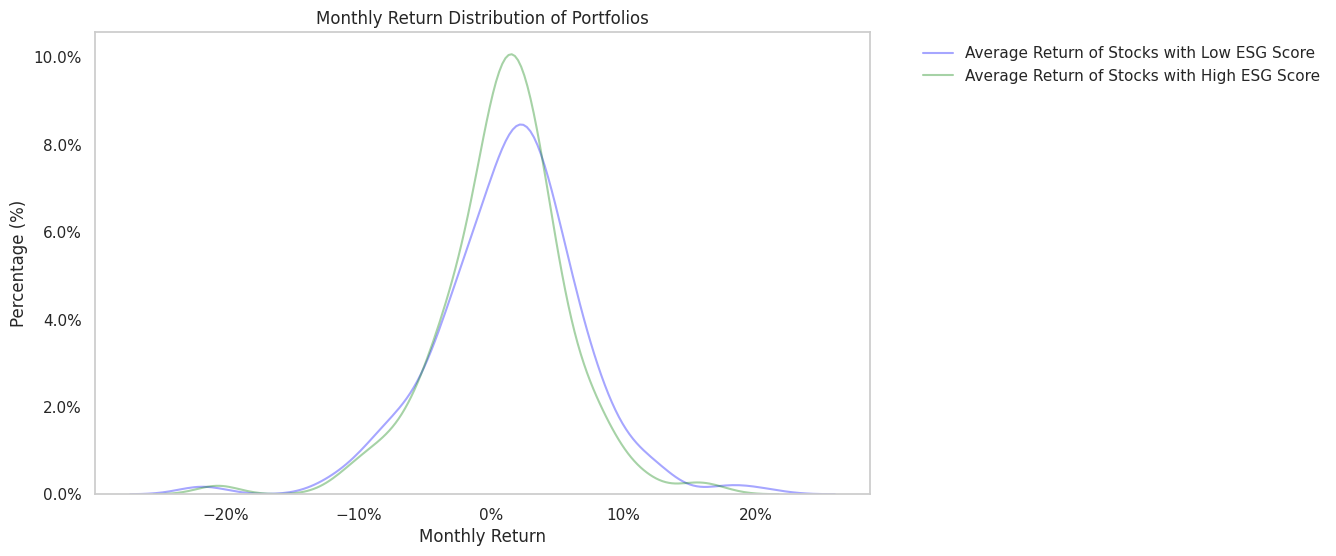

In [43]:
plt.figure(figsize=(10, 6), dpi=100)

sns.kdeplot(return_history_inspect['Average_Return_Low'], color='blue', label='Average Return of Stocks with Low ESG Score', fill=False, alpha=0.35)
sns.kdeplot(return_history_inspect['Average_Return_High'], color='green', label='Average Return of Stocks with High ESG Score', fill=False, alpha=0.35)

plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1.0))
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=100))

# Add labels and title
plt.xlabel('Monthly Return')
plt.ylabel('Percentage (%)')
plt.title('Monthly Return Distribution of Portfolios')

# Add legend
plt.legend(bbox_to_anchor = (1.05, 1), loc = "upper left", frameon = False)

#Remove Grid
plt.grid(visible = False)

# Show plot
plt.show()

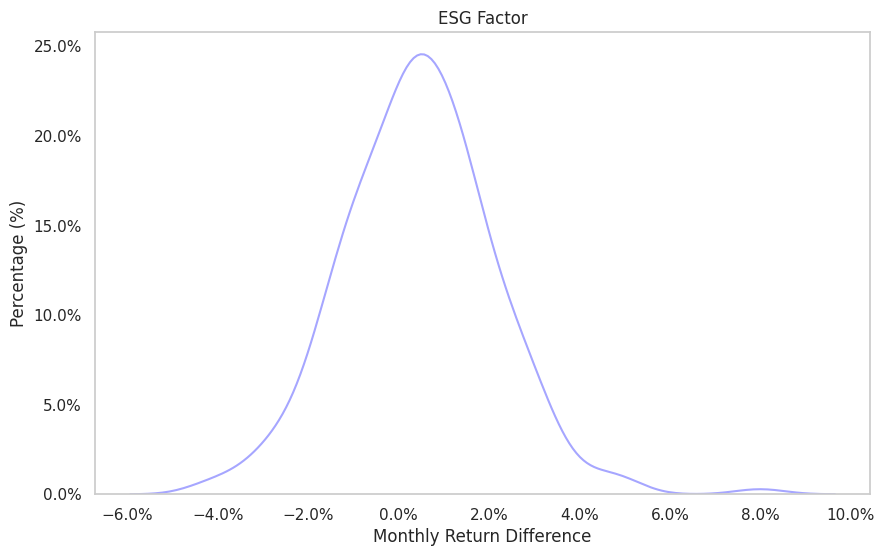

In [44]:
plt.figure(figsize=(10, 6), dpi=100)

sns.kdeplot(return_history_inspect['ESG_Factor'], color='blue', fill=False, alpha=0.35)

plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1.0))
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=100))

# Add labels and title
plt.xlabel('Monthly Return Difference')
plt.ylabel('Percentage (%)')
plt.title('ESG Factor')

#Remove Grid
plt.grid(visible = False)

# Show plot
plt.show()

In [45]:
initial_investment = 100

# Calculate cumulative growth factor for each stock
return_history_inspect["Portfolio_Value_High"] = initial_investment * (1 + return_history_inspect["Average_Return_High"]).cumprod()
return_history_inspect["Portfolio_Value_Low"] = initial_investment * (1 + return_history_inspect["Average_Return_Low"]).cumprod()

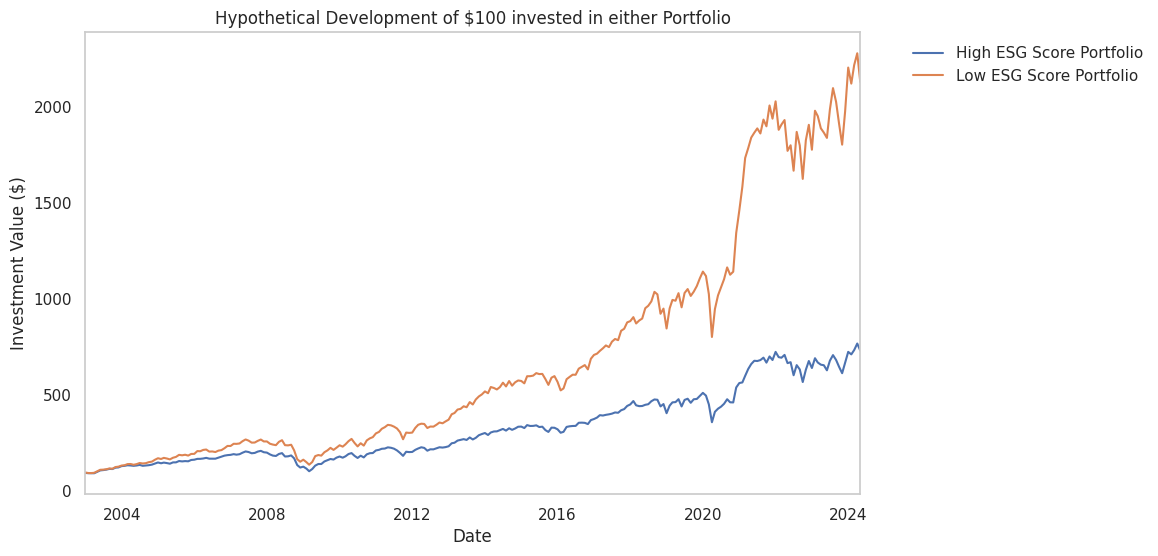

In [46]:
# Plot the investment growth for each stock over time
plt.figure(figsize=(10, 6))

sns.lineplot(y = "Portfolio_Value_High", x = "Date", label = "High ESG Score Portfolio", data = return_history_inspect)
sns.lineplot(y = "Portfolio_Value_Low", x = "Date", label = "Low ESG Score Portfolio", data = return_history_inspect)

# Adding labels and title
plt.title("Hypothetical Development of $100 invested in either Portfolio")

plt.xlabel("Date")
plt.ylabel("Investment Value ($)")

plt.legend(bbox_to_anchor = (1.05, 1), loc = "upper left", frameon = False)

plt.grid(visible = False)
plt.xlim(return_history_inspect["Date"].min(), return_history_inspect["Date"].max())

plt.show()